In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import sys
sys.path.append('..')
import ca2_mec.project_path
import expipe_plugin_cinpla
from expipe_plugin_cinpla.tools.trackunitmulticomparison import TrackMultipleSessions
import expipe_plugin_cinpla.tools.data_processing as dp
from expipe_plugin_cinpla.tools.registration import store_notebook
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import quantities as pq
from distutils.dir_util import copy_tree
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import networkx as nx
#from nxpd import draw
%matplotlib inline

In [3]:
project_path = ca2_mec.project_path.project_path()
project = expipe.get_project(project_path)
actions = project.actions

identify_neurons = project.require_action('identify-neurons')
data_loader = dp.Data(project)

In [4]:
#include = ['013-050521-1', '013-050521-2', '013-050521-3', '013-050521-4', '013-050521-5']
include = ['001-181220-2', '001-181220-3', '001-181220-4', '001-181220-5', '001-181220-6', 
        '001-191220-1', '001-191220-3', '001-191220-6', '001-191220-7', '001-191220-8']
#include = ['001-211220-1', '001-211220-2', '001-211220-3', '001-211220-4', '001-211220-5',
#         '001-221220-1', '001-221220-2', '001-221220-3', '001-221220-4', '001-221220-5']
#include = ['001-280721-1', '001-280721-2', '001-280721-3', '001-280721-4', '001-280721-5'] #Maria sine opptak fra MEC
#include = ['002-050721-1', '002-050721-2', '002-050721-3', '002-050721-4', '002-050721-5'] #Maria sine opptak fra MEC
#include = ['001-140721-2', '001-140721-3', '001-140721-4', '001-140721-5', '001-140721-6', '001-140721-7'] #Maria, novel


#include = ['013-050521-1', '013-050521-2', '013-050521-3', '013-050521-4', '013-050521-5']
#include = ['011-120321-2', '011-120321-3', '011-120321-4', '011-120321-5', '011-120321-6']
#include = ['022-160322-1', '022-160322-2', '022-160322-3', '022-160322-4', '022-160322-5', '022-160322-7']
#include = ['007-081221-1','007-081221-2','007-081221-3', '007-081221-4','007-081221-5','007-081221-6']

# find the complement of include
skip_actions = []
for action in actions:
    if action not in include:
        skip_actions.append(action)
skip_actions, include

(['identify-neurons'],
 ['001-181220-2',
  '001-181220-3',
  '001-181220-4',
  '001-181220-5',
  '001-181220-6',
  '001-191220-1',
  '001-191220-3',
  '001-191220-6',
  '001-191220-7',
  '001-191220-8'])

In [5]:
sessions = []
for action in actions.values():
    if action.id in skip_actions:
        continue
    if action.type != 'Recording':
        continue
    print(action.id)
    action_data_path = dp.get_data_path(action)

    sessions.append({
       'action': action.id,
       'session': int(action.id.split('-')[-1]),
       'entity': action.entities[0],

   })
sessions = pd.DataFrame(sessions)

001-191220-6
001-191220-3
001-191220-8
001-181220-3
001-181220-5
001-191220-7
001-181220-6
001-181220-2
001-191220-1
001-181220-4


In [6]:
sessions['date'] = sessions.apply(lambda x: x.action.split('-')[1], axis=1)
sessions['entity_date'] = sessions.apply(lambda x: '-'.join(x.action.split('-')[:2]), axis=1)
sessions.to_csv(identify_neurons.data_path() / 'sessions.csv', index=False)
sessions

,action,session,entity,date,entity_date
0,001-191220-6,6,001,191220,001-191220
1,001-191220-3,3,001,191220,001-191220
2,001-191220-8,8,001,191220,001-191220
3,001-181220-3,3,001,181220,001-181220
4,001-181220-5,5,001,181220,001-181220
5,001-191220-7,7,001,191220,001-191220
6,001-181220-6,6,001,181220,001-181220
7,001-181220-2,2,001,181220,001-181220
8,001-191220-1,1,001,191220,001-191220
9,001-181220-4,4,001,181220,001-181220


# Identify unique neurons

In [7]:
sessions_include = sessions
sessions_include

#sessions_include = sessions.query("action.isin(@immutable_include)")


#Older option for this cell:
#sessions_include = sessions.query("action.isin(@include)")
#sessions_include


,action,session,entity,date,entity_date
0,001-191220-6,6,001,191220,001-191220
1,001-191220-3,3,001,191220,001-191220
2,001-191220-8,8,001,191220,001-191220
3,001-181220-3,3,001,181220,001-181220
4,001-181220-5,5,001,181220,001-181220
5,001-191220-7,7,001,191220,001-191220
6,001-181220-6,6,001,181220,001-181220
7,001-181220-2,2,001,181220,001-181220
8,001-191220-1,1,001,191220,001-191220
9,001-181220-4,4,001,181220,001-181220


In [15]:
# save graphs
for entity, values in sessions_include.groupby('entity'):
    print(entity, values)
    data_path = identify_neurons.data_path() / f'{entity}-graphs'
    if data_path.exists():
        shutil.rmtree(data_path)
#         continue
    unit_matching = TrackMultipleSessions(
        actions, action_list=values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.do_matching()
    unit_matching.make_graphs_from_matches()     
    unit_matching.compute_time_delta_edges()
    unit_matching.compute_depth_delta_edges()
    # save graph with all dissimilarities for later use
    unit_matching.save_graphs()

001          action  session entity    date entity_date
0  001-191220-6        6    001  191220  001-191220
1  001-191220-3        3    001  191220  001-191220
2  001-191220-8        8    001  191220  001-191220
3  001-181220-3        3    001  181220  001-181220
4  001-181220-5        5    001  181220  001-181220
5  001-191220-7        7    001  191220  001-191220
6  001-181220-6        6    001  181220  001-181220
7  001-181220-2        2    001  181220  001-181220
8  001-191220-1        1    001  191220  001-191220
9  001-181220-4        4    001  181220  001-181220


  0%|          | 0/45 [00:00<?, ?it/s]

# Plot comparisons

In [16]:
entity = "001"
max_dissimilarity = 0.05 #default is 0.05
#max_depth_delta = 100

unit_comp = TrackMultipleSessions(
    actions, sessions_include.action.values, data_path=identify_neurons.data_path() / f'{entity}-graphs')

unit_comp.load_graphs()

unit_comp.remove_edges_above_threshold('weight', max_dissimilarity)
unit_comp.remove_edges_above_threshold('depth_delta', max_depth_delta)

unit_comp.remove_edges_with_duplicate_actions()
unit_comp.identify_units()

Zero units found on channel group tetrode2
Zero units found on channel group tetrode5
Zero units found on channel group tetrode3
Zero units found on channel group tetrode4
Zero units found on channel group tetrode1
Zero units found on channel group tetrode6
Zero units found on channel group tetrode7


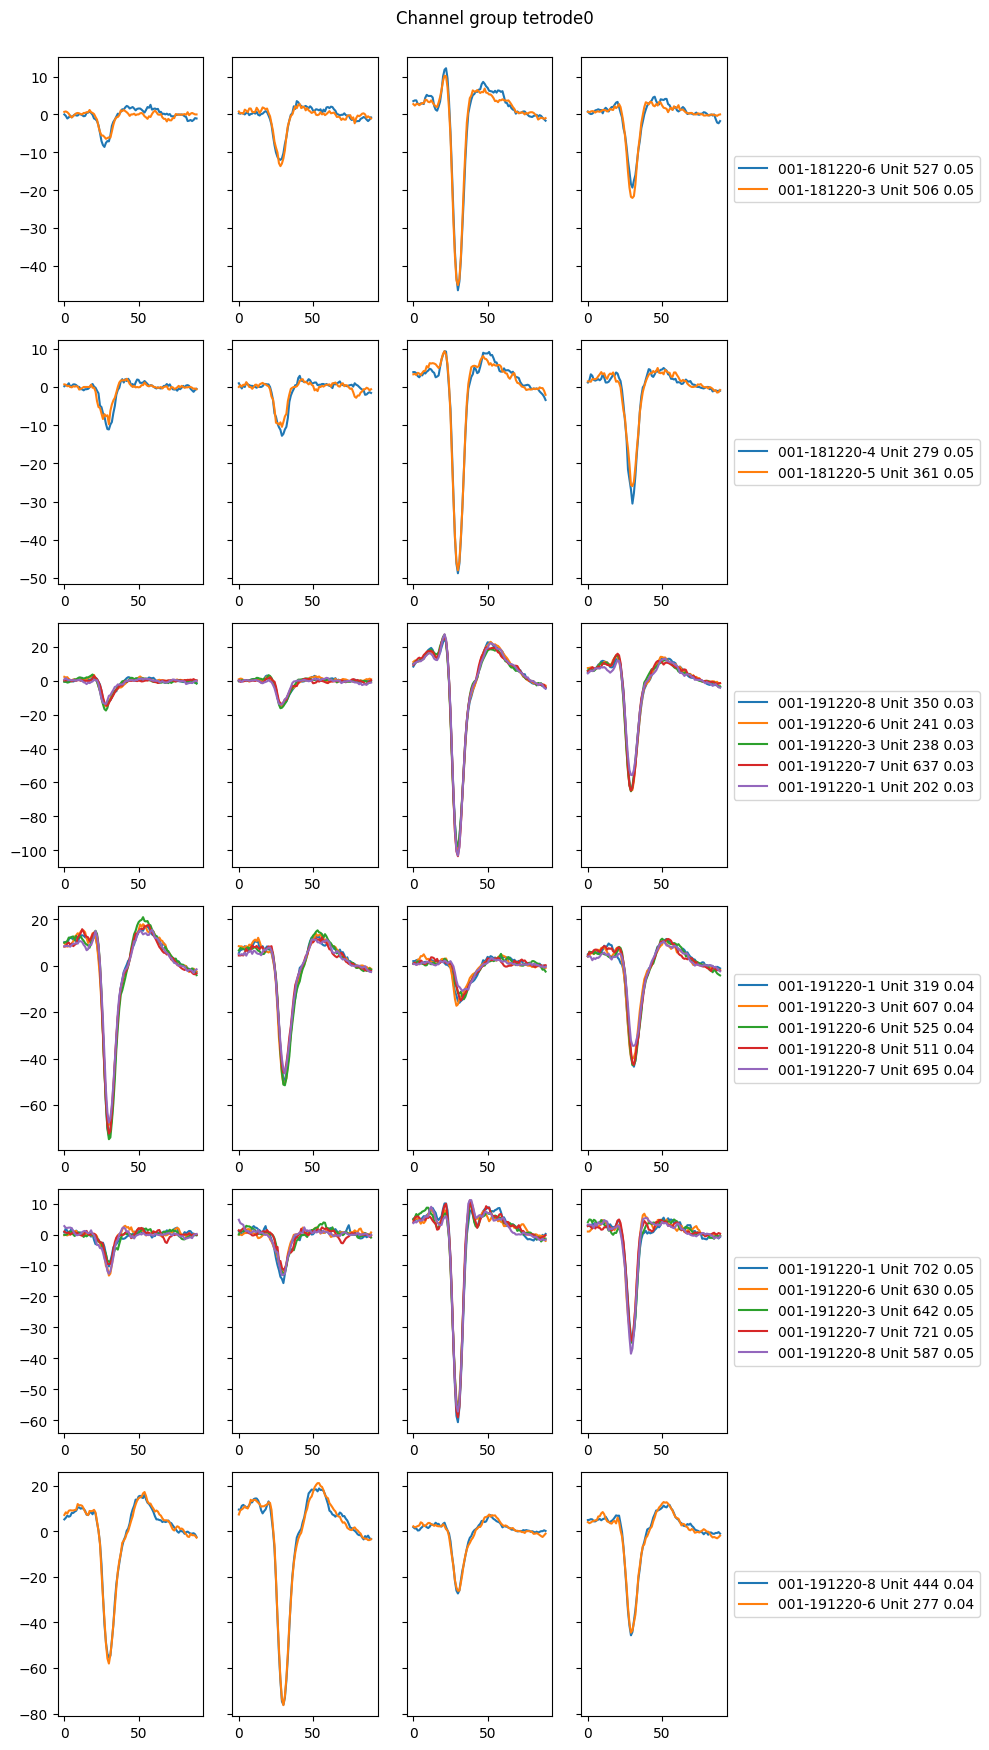

In [17]:
#unit_comp.plot_matches(chan_group='tetrode1', step_color=False)
unit_comp.plot_matches(step_color=False)

#plt.tight_layout()

# Store uniqe unit ids to csv

In [18]:
max_dissimilarity = .05 #default 0.05
max_depth_delta = 100
id_nums = {}
num = 0
output = identify_neurons.data_path()

for entity, values in sessions_include.groupby('entity'):
    data_path = output / f'{entity}-graphs'
    unit_matching = TrackMultipleSessions(
        actions, values.action.values.tolist(), 
        progress_bar=tqdm, verbose=False, data_path=data_path
    )
    unit_matching.load_graphs()
    # cutoff large dissimilarities
    unit_matching.remove_edges_above_threshold('weight', max_dissimilarity)
    unit_matching.remove_edges_above_threshold('depth_delta', max_depth_delta)
    unit_matching.remove_edges_with_duplicate_actions()
    unit_matching.identify_units()
    units = []
    for ch, group in unit_matching.identified_units.items():
        for unit_id, val in group.items():
            for action_id, orig_unit_ids in val['original_unit_ids'].items():
                if unit_id not in id_nums:
                    id_nums[unit_id] = num
                    num += 1
                units.extend([
                    {
                        'unit_name': name, 
                        'unit_idnum': id_nums[unit_id],
                        'unit_id': unit_id, 
                        'action': action_id,
                        'channel_group': ch,
                        'max_dissimilarity': max_dissimilarity,
                        'max_depth_delta': max_depth_delta
                    } 
                    for name in orig_unit_ids])
    units = pd.DataFrame(units)
    units = units[~units.action.isin(skip_actions)]
    units.to_csv(output / f'{entity}-units.csv', index=False)

In [19]:
unique_units = pd.concat([
    pd.read_csv(p) 
    for p in output.iterdir() 
    if p.name.endswith('-units.csv')])

In [20]:
unique_units.to_csv(output / 'units.csv', index=False)

# Store results in Expipe action

In [21]:
identify_neurons.data['sessions'] = 'sessions.csv'
identify_neurons.data['units'] = 'units.csv'

In [22]:
copy_tree(output, str(identify_neurons.data_path()))

['/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/sessions.csv',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode2.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode5.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode3.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode4.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode1.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode0.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs/graph-group-tetrode6.yaml',
 '/projects/ec109/Sarah/projects/hpc-social-nwb/actions/identify-neurons/data/001-graphs

In [23]:
store_notebook(
    identify_neurons, "00-identify-neurons.ipynb")

[NbConvertApp] Converting notebook 00-identify-neurons.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 697736 bytes to 00-identify-neurons.html


## Load and view results

In [24]:
pd.read_csv(output / "units.csv")

,unit_name,unit_idnum,unit_id,action,channel_group,max_dissimilarity,max_depth_delta
0,613,0,4f37ff63-80f1-484f-bca0-ba660a436ca5,001-181220-2,tetrode0,0.05,100
1,527,1,d84c578b-e9a5-42c7-a22e-2e87d69ebf9c,001-181220-6,tetrode0,0.05,100
2,506,1,d84c578b-e9a5-42c7-a22e-2e87d69ebf9c,001-181220-3,tetrode0,0.05,100
3,279,2,60af046b-4994-4975-976d-27c6d4e62b7c,001-181220-4,tetrode0,0.05,100
4,361,2,60af046b-4994-4975-976d-27c6d4e62b7c,001-181220-5,tetrode0,0.05,100
5,350,3,78a12a39-c4f2-49b4-bd37-8026383da407,001-191220-8,tetrode0,0.05,100
6,241,3,78a12a39-c4f2-49b4-bd37-8026383da407,001-191220-6,tetrode0,0.05,100
7,238,3,78a12a39-c4f2-49b4-bd37-8026383da407,001-191220-3,tetrode0,0.05,100
8,637,3,78a12a39-c4f2-49b4-bd37-8026383da407,001-191220-7,tetrode0,0.05,100
9,202,3,78a12a39-c4f2-49b4-bd37-8026383da407,001-191220-1,tetrode0,0.05,100


In [25]:
pd.read_csv(output / "units.csv")["unit_id"].unique()

array(['4f37ff63-80f1-484f-bca0-ba660a436ca5',
       'd84c578b-e9a5-42c7-a22e-2e87d69ebf9c',
       '60af046b-4994-4975-976d-27c6d4e62b7c',
       '78a12a39-c4f2-49b4-bd37-8026383da407',
       '5a67f04b-7a5b-468b-8f0d-c3f4b20cb83c',
       '2b1526dc-e81e-4059-83f5-e9e8ce409046',
       '6f80546f-a636-4687-b3af-e90620472d70',
       '31a4122f-a78d-4158-969b-8efd3214f81c',
       'deff453c-5111-41c1-954d-8850a64055f4',
       '70aa50da-8f43-4e32-bade-b8b28e1e7a82',
       'f74a4394-810e-40ee-a789-af3603526fd1',
       'e7aed060-59a1-41b3-8e63-71e7039b6255'], dtype=object)